<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_Animation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Animation (v2)
Formalising the results of v1 into the code repo.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout 2a24a30
#!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam_models
import slam_operations
import slam_operations_test
import slam_data
import slam_data_test
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_operations)
reload(slam_operations_test)
reload(slam_data)
reload(slam_data_test)

slam_operations_test.run_test_suite()

Cloning into 'repo'...
remote: Enumerating objects: 786, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 786 (delta 148), reused 264 (delta 146), pack-reused 518 (from 1)
Receiving objects: 100% (786/786), 69.65 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (415/415), done.
Already up to date.


In [2]:
!pip install -Uqq ipdb

from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import tarfile
import imageio.v3 as iio
import IPython.display as display
import math
import ipdb
import gc
import datetime
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00


## Animate Trajectory

floorplan: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


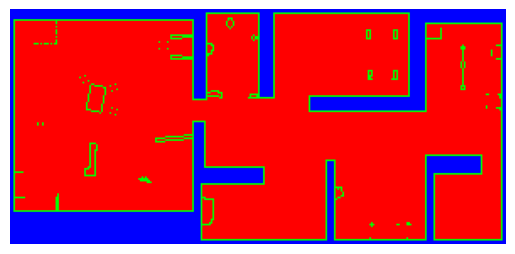

In [3]:
# Load floorplan
reload(slam_data)

floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

plt.imshow(floorplan)
plt.axis('off')
plt.show()

contour: (1286, 2)
coords: (129, 2)
angles: (129,)


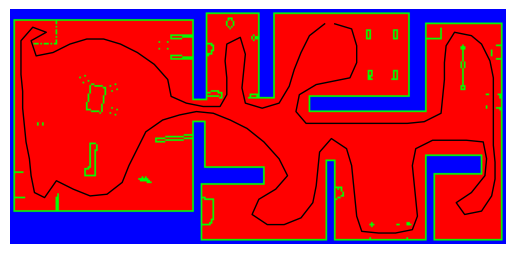

In [4]:
reload(slam_operations)
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')
contour_px = slam_operations.load_trajectory_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
trajectory_coords, trajectory_angles = slam_operations.sample_trajectory(contour_px)
print(f"contour: {contour_px.shape}")
print(f"coords: {trajectory_coords.shape}")
print(f"angles: {trajectory_angles.shape}")

slam_operations.show_trajectory(floorplan, trajectory_coords)


Generating animation and saving to: animation.gif


100%|██████████| 129/129 [00:21<00:00,  6.02it/s]



Animation saved to: animation.gif


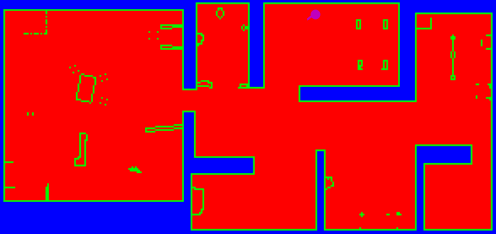

In [5]:
#slam_operations.animate_trajectory(floorplan, trajectory_coords[0:5], trajectory_angles)

slam_operations.animate_trajectory(floorplan, trajectory_coords, trajectory_angles, filename='trajectory_animation.gif')


## Animate SLAM

In [3]:
# Load model
model = tf.keras.models.load_model('slam-model1-200epochs.keras')
print(f"Model loaded:")
print(f"  Inputs:           {model.inputs}")
print(f"  Outputs:          {model.outputs}")
print(f"  Layers:           {len(model.layers)}")

Model loaded:
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_122>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_124>]
  Layers:           60


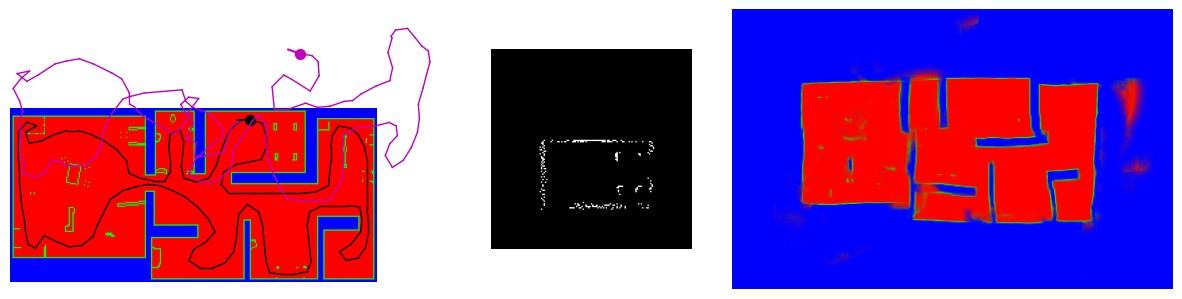

100%|██████████| 129/129 [01:10<00:00,  1.84it/s]


In [26]:
reload(slam_operations)
step_size = 10 * lds.__PIXEL_SIZE__
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')
contour_px = slam_operations.load_trajectory_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
trajectory_coords, trajectory_angles = slam_operations.sample_trajectory(contour_px, step_size=step_size)

#indices = slice(0, 50)
#indices = slice(0, trajectory_coords.shape[0], 5)
#indices = slice(0, trajectory_coords.shape[0])
#trajectory_coords = trajectory_coords[indices]
#trajectory_angles = trajectory_angles[indices]


# Animate directly on screen
slam_operations.animate_slam(floorplan, trajectory_coords, trajectory_angles, model,
                             state_follows='true', map_update_mode='mask-merge', clip=False)

# Generate GIF
#slam_operations.animate_slam(floorplan, trajectory_coords, trajectory_angles, model, filename='slam_animation.gif',
#                             state_follows='true', map_update_mode='mask-merge', clip=False, fps=5)

## Learnings
* When moving 1px per step it's obvious that there's an off-by-one error in the internal maths causing the features in the output map to slowly shift away from their correct location. As the global map is updated, you see the nearest walls sliding in one direction or another, depending on the direction of motion. Then when the wall has shifted enough, the model finally corrects itself by placing a new wall where it belongs, but it leaves the old shifted wall in the map as well, doubling up on the walls.
* I might even see this effect by just leaving the agent in one place and running the model multiple times.
* Fixing this seems like an obvious first step towards getting the model to be more accurate for tracking.